In [79]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# This will automatically reload src/dtree.py every time you make changes and save the file
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
%matplotlib inline

In [81]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [82]:
df = pd.read_csv('./train.csv/train.csv')

In [83]:
print(df.shape)
print(df.columns.to_list())
print(df.iloc[0])

(16784, 30)
['listing_id', 'title', 'make', 'model', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'indicative_price', 'price']
listing_id                                                     1030324
title                           BMW 3 Series 320i Gran Turismo M-Sport
make                                                               bmw
model                                                             320i
description          1 owner! 320i gt m-sports model! big brake kit...
manufactured                                                    2013.0
original_reg_date                                                  NaN
reg_date                                                   09-dec-2013
type_of_vehicle             

In [84]:
missing_make = np.array(df['make'].isnull())
print(missing_make.sum())

2160


In [85]:
def extract_model(de):
    model_list = ['alfa romeo', 'alpine', 'aston martin', 'audi', 'austin', 'bentley', 'bmw',
 'byd', 'chery', 'chevrolet', 'chrysler', 'citroen', 'cupra', 'daf', 'daihatsu',
 'daimler', 'dodge', 'dongfeng', 'ferrari', 'fiat', 'ford', 'foton',
 'golden dragon', 'hafei', 'higer', 'hino', 'honda', 'hummer', 'hyundai',
 'infiniti', 'international', 'isuzu', 'iveco', 'jaguar', 'jeep', 'joylong',
 'kia', 'lamborghini', 'land rover', 'lexus', 'lotus', 'man', 'maserati', 'maxus',
 'mazda', 'mclaren', 'mercedes', 'mercedes-benz', 'mg', 'mini', 'mitsubishi',
 'mitsuoka', 'morris', 'nissan', 'opel', 'perodua', 'peugeot', 'porsche',
 'proton', 'renault', 'riley', 'rolls-royce', 'rover', 'ruf', 'saab', 'scania',
 'seat', 'skoda', 'ssangyong', 'subaru', 'suzuki', 'tesla', 'toyota', 'ud',
 'volkswagen', 'volvo', 'yutong']
    des = de.split(' ')
    for d in des:
        if d in model_list:
            return d
    return False

df['title'] = df['title'].str.lower().replace('-', '')
make_from_titles = df['title'].map(extract_model)
b = np.array(make_from_titles, dtype=bool)
remains = np.logical_and(b, missing_make)
df['make'][remains] = make_from_titles[remains]
#2103 make filled

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [86]:
d1 = np.array(df['original_reg_date'].isnull())
df['age'] = df['original_reg_date'].copy()
df['age'][d1] = df['reg_date'][d1]
d1 = df['age'].isnull()
df['age'][d1] = df['manufactured'][d1]

def extract_year(date):
    date = str(date)
    if len(date) != 4:
        if '.' in date and len(date) == 6:
            year = date[:-2]
        else:
            l = date.split('-')
            year = l[-1]
    return int(year)
df['age'] = 2021 - df['age'].map(extract_year)

G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
G:\softwares\envs\4277lab\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [87]:
# take out outliers
df['age'] = df['age'][df.age < 30]
df['age'] = df['age'][df.age >= 0]

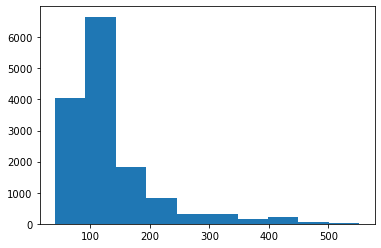

In [88]:
# power
plt.figure()
plt.hist(df["power"].to_numpy())
plt.show()

In [89]:
print(len(df[df.power > 400]))
print(df["power"].isnull().sum())

310
2337


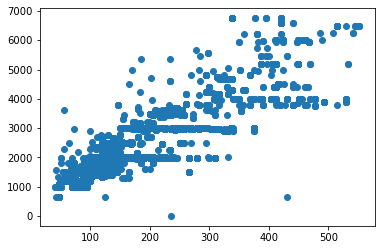

In [90]:
# plot correlation between power and engine cap
plt.scatter(df["power"], df["engine_cap"])
plt.show()

In [91]:
# engine cap
print(df["engine_cap"].isnull().sum())
df = df.dropna(subset = ["engine_cap"]) # only dropping 53

53


In [92]:
# take out outliers acccording to scatter plot
df = df[~((df['power'] > 200) & (df['engine_cap'] < 1000))]

df_valid = df.dropna(subset = ['power'])
powers = df_valid['power'].to_numpy()
caps = df_valid['engine_cap'].to_numpy()

# Find k data points with engine cap most similar to the power of x
# Calculate the median power of those k data points
# Set power of x to the calculated median
# Set k as the number of nearest data points we want to consider
k = 100

# Loop over each data point in our dataset
for idx, row in df.iterrows():
    if idx % 10000 == 0:
        print(idx)

    p, e = row['power'], row['engine_cap']

    diff = np.abs(caps - e)

    indices = np.argsort(diff)[:k]

    k_powers = powers[indices]

    avg = np.average(k_powers)
    
    # Set the weight value of the current row to the median
    df.at[idx, 'power'] = avg

0
10000


In [93]:
print(df['mileage'].isnull().sum())
df['mileage'] = df['mileage'].fillna(df['mileage'].mode())

3705


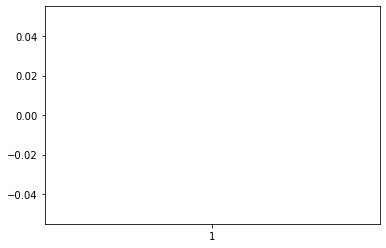

In [94]:
plt.figure()
plt.boxplot(df["mileage"])
plt.show()

In [95]:
df = df[df.mileage < 400000]

In [96]:
# coe: fill in missing value for coe according to: age and power
print(df["arf"].isnull().sum()) #284
print(len(df[df.arf.isnull() & df.dereg_value.isnull()])) #222
df = df[~(df.arf.isnull() & df.dereg_value.isnull())] # remove values whose dereg_value cannot be calculated

148
135


In [97]:
# recalculate reg date: total months
def to_months(x):
    mapper = {}
    all_m = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    for i in range(12):
        mapper[all_m[i]] = i + 1
    if len(str(x)) < 11:
        return int(x)
    s = x.split('-')
    year = 2021 - int(s[-1])
    month = mapper[s[-2]]
    return year * 12 + month

df = df.dropna(subset = ['reg_date'])
df['age_in_month'] = df['reg_date'].map(to_months)

In [98]:
# for date missing both coe and dereg_value, record it's month engine and power
coe_to_search = []
to_search = df[df.coe.isnull() & df.dereg_value.isnull()]

for idx, row in to_search.iterrows():
    # category -> A / B
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    coe_to_search.append((cat, month))

coe_to_search = list(set(coe_to_search))
print(len(coe_to_search))

60


In [99]:
t_to_coe = {}

for t in coe_to_search:
    t_to_coe[str(t)] = []

remains = df[~df.coe.isnull()]

for idx, row in remains.iterrows():
    if idx % 10000 == 0:
        print(idx)

    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    
    t = (cat, month)
    
    coe = row["coe"]
    if t in coe_to_search:
        t_to_coe[str(t)].append(coe)
        
c = 0
for idx, row in df.iterrows():
    power = row["power"]
    engine_cap = row["engine_cap"]
    cat = 2
    month = row["age_in_month"]
    if engine_cap <= 1600 and power <= 97:
        cat = 1
    t = str((cat, month))

    if type(row["coe"]) == float and pd.isna(row["coe"]):
        l = t_to_coe[t]
        if len(l) > 0:
            avg = sum(l) / len(l)
            df.at[idx, 'coe'] = avg
            c += 1
print(c)

0
10000
635


In [100]:
print(df['coe'].isnull().sum())

35


In [101]:
df = df[~(df.coe.isnull() & df.dereg_value.isnull())]

In [102]:
def clean_tax(x):
    if type(x) != float:
        return None
    return x
df = df.dropna(subset=["road_tax"])
df["road_tax"] = df["road_tax"].map(clean_tax)

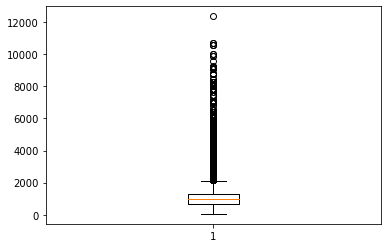

In [103]:
plt.figure()
plt.boxplot(df["road_tax"])
plt.show()

In [104]:
print(df["road_tax"].median())

974.0


In [105]:
import math
for idx, row in df.iterrows():
    rd_tax = row["road_tax"]
    if type(rd_tax) == float and pd.isna(rd_tax):
        rd_tax = 974.0
    if type(row["dereg_value"]) == float and pd.isna(row["dereg_value"]):
        max_age = 10 * 12
        age = row["age_in_month"]
        time_left = max_age - age
        coe = row["coe"]
        omv = row["omv"]
        arf = row["arf"]
        parf_ratio = 0
        if age <  5 * 12:
            parf_ratio = 0.75
        elif age >= 5 * 12 and age < 10 * 12:
            parf_ratio = 0.75 - math.ceil((age - 5 * 12) / 12) * 0.05 
        coe_rebate = coe * time_left / 120
        dereg_value = parf_ratio * arf + coe_rebate
        df.at[idx, "remaining_val"] = dereg_value - rd_tax
        df.at[idx, "dereg_value"] = dereg_value
    else:
        df.at[idx, "remaining_val"] = row["dereg_value"] - rd_tax

In [106]:
df = df.dropna(subset = ['depreciation'])

In [107]:
print(df.columns.to_list())

['listing_id', 'title', 'make', 'model', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'curb_weight', 'power', 'fuel_type', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'indicative_price', 'price', 'age', 'age_in_month', 'remaining_val']


In [108]:
# remove extra  attributes and final cleanup
df = df.drop(columns = ['listing_id', 'title', 'model', 'description', 'manufactured', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'fuel_type', 'no_of_owners', 'coe', 'road_tax', 'dereg_value', 'omv', 'arf', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'indicative_price'])

In [109]:
print(df.shape)

(12015, 9)


In [110]:
df.head()

,make,power,engine_cap,depreciation,mileage,price,age,age_in_month,remaining_val
0,bmw,145.580,1997.0,17700.0,73000.0,71300.0,8.0,108,46304.0
2,mercedes-benz,100.720,1595.0,15070.0,80000.0,95500.0,5.0,67,43777.0
3,mercedes-benz,92.360,1497.0,16400.0,9800.0,197900.0,1.0,23,79617.0
4,honda,101.483,1597.0,10450.0,40000.0,103200.0,2.0,33,35711.0
6,volvo,98.330,1498.0,11020.0,77777.0,62500.0,6.0,84,36627.0
